In [86]:
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf    
import keras
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")   

In [ ]:
data_dir = "../data/archive"

# Load the training CSV file
train_csv = pd.read_csv(os.path.join(data_dir, "Train.csv"))

# Number of unique classes (should be 43)
nb_classes = train_csv["ClassId"].nunique()
print("Number of classes:", nb_classes)

classes = {
    0:'Speed limit (20km/h)', 1:'Speed limit (30km/h)', 2:'Speed limit (50km/h)',
    3:'Speed limit (60km/h)', 4:'Speed limit (70km/h)', 5:'Speed limit (80km/h)',
    6:'End of speed limit (80km/h)', 7:'Speed limit (100km/h)', 8:'Speed limit (120km/h)',
    9:'No passing', 10:'No passing veh over 3.5 tons', 11:'Right-of-way at intersection',
    12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 16:'Veh > 3.5 tons prohibited',
    17:'No entry', 18:'General caution', 19:'Dangerous curve left', 20:'Dangerous curve right',
    21:'Double curve', 22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right',
    25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing',
    29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing',
    32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead',
    35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 38:'Keep right',
    39:'Keep left', 40:'Roundabout mandatory', 41:'End of no passing', 42:'End no passing veh > 3.5 tons'
}

# Create a mapping: classid -> class name
class_names_label = classes

# Example lookup
print("Class 2 means:", class_names_label[3])

Number of classes: 43
Class 2 means: Speed limit (60km/h)


In [92]:
IMAGE_SIZE = (64, 64)
def load_data(df, base_dir):
    images = []
    labels = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(base_dir, row["Path"])
        label = row["ClassId"]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, IMAGE_SIZE)

        # Normalization
        image = image.astype("float32") / 255.0

        images.append(image)
        labels.append(label)

    images = np.array(images, dtype="float32")
    labels = np.array(labels, dtype="int32")
    return images, labels


# load
test_csv  = pd.read_csv(os.path.join(data_dir, "Test.csv"))

train_images, train_labels = load_data(train_csv, data_dir)
test_images, test_labels = load_data(test_csv, data_dir)

100%|██████████| 12630/12630 [00:36<00:00, 344.91it/s]


In [93]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
test_images, test_labels = shuffle(test_images, test_labels, random_state=25)

In [94]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples:", n_train)
print("Number of testing examples:", n_test)
print("Each image is of size:", IMAGE_SIZE)

Number of training examples: 39209
Number of testing examples: 12630
Each image is of size: (64, 64)


In [95]:
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels, test_size=0.15, random_state=44, stratify=train_labels
)
X_test,y_test = (train_images, train_labels)

# normalize
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test/255.0

In [109]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(
            32, (3, 3), activation="relu", input_shape=(64, 64, 3)
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.Dropout(rate=0.15),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
        tf.keras.layers.Conv2D(256, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dropout(rate=0.25),
        tf.keras.layers.Dense(43, activation="softmax", dtype="float32"),
    ]
)


In [112]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [100]:
history = model.fit(
    X_train,
    y_train,
    batch_size = 100,
    epochs = 20,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 105s 313ms/step - accuracy: 0.7361 - loss: 1.0086 - val_accuracy: 0.8072 - val_loss: 0.6938
Epoch 2/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 142s 312ms/step - accuracy: 0.8347 - loss: 0.6042 - val_accuracy: 0.8720 - val_loss: 0.4823
Epoch 3/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 109s 325ms/step - accuracy: 0.8664 - loss: 0.4906 - val_accuracy: 0.8739 - val_loss: 0.4464
Epoch 4/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 108s 325ms/step - accuracy: 0.8832 - loss: 0.4261 - val_accuracy: 0.8920 - val_loss: 0.3815
Epoch 5/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 101s 302ms/step - accuracy: 0.9047 - loss: 0.3656 - val_accuracy: 0.9113 - val_loss: 0.3325
Epoch 6/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 98s 294ms/step - accuracy: 0.9121 - loss: 0.3292 - val_accuracy: 0.9043 - val_loss: 0.3460
Epoch 7/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 102s 305ms/step - accuracy: 0.9171 - loss: 0.3071 - val_accuracy: 0.9080 - val_loss: 0.3274
Epoch 8/20
334/334 ━━━━━━━━━━━━━━━━━━━━ 107s 320ms/step - accuracy: 0.9229 - 

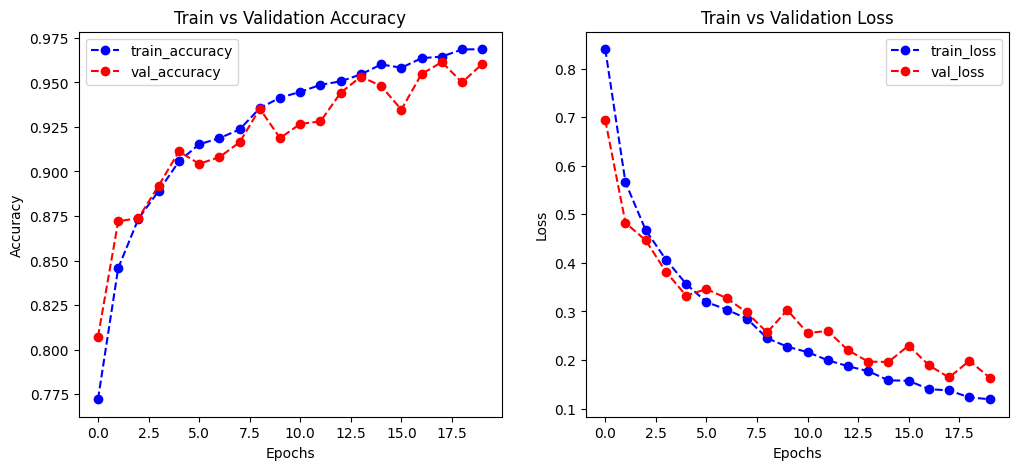

In [101]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(12,5))

    # Plot accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], 'bo--', label='train_accuracy')
    plt.plot(history.history['val_accuracy'], 'ro--', label='val_accuracy')
    plt.title("Train vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], 'bo--', label='train_loss')
    plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
    plt.title("Train vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()
plot_accuracy_loss(history=history)

In [102]:
pred_probs = model.predict(test_images)         
pred_labels = np.argmax(pred_probs, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step


In [103]:
classes = [str(i) for i in range(43)]

print("Classification Report:")
print(classification_report(test_labels, pred_labels, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.63      0.39        60
           1       0.50      0.76      0.60       720
           2       0.61      0.56      0.58       750
           3       0.78      0.37      0.50       450
           4       0.80      0.58      0.67       660
           5       0.58      0.49      0.53       630
           6       1.00      0.22      0.36       150
           7       0.69      0.57      0.63       450
           8       0.63      0.45      0.53       450
           9       0.70      0.89      0.78       480
          10       0.96      0.78      0.86       660
          11       0.64      0.14      0.23       420
          12       0.81      0.96      0.88       690
          13       0.81      0.94      0.87       720
          14       0.88      0.99      0.93       270
          15       0.63      0.76      0.69       210
          16       0.94      0.31      0.47       150
    

In [105]:
loss, acc = model.evaluate(test_images, test_labels, verbose=0)
print("Test accuracy:", acc)

Test accuracy: 0.6253365278244019


In [108]:
model.save("/kaggle/working/Traffic_Detection.keras")